# 5. Pretraining on UnLabeled data

In [1]:
from importlib.metadata import version

import torch

pkgs = ["matplotlib", "numpy", "tiktoken", "torch", "tensorflow"]

for pkg in pkgs:
    print(f"{pkg}: {version(pkg)}")

matplotlib: 3.10.1
numpy: 2.0.2
tiktoken: 0.9.0
torch: 2.6.0
tensorflow: 2.18.0


## 5.1. Evaluating generative text models

### 5.1.1. Using GPT to generate Text

In [2]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,  # Vocabulary size
    "context_length": 256,  # Context length
    "emb_dim": 768,  # Embedding dimension
    "n_heads": 12,  # Number of attention heads
    "n_layers": 12,  # Number of layers
    "drop_rate": 0.1,  # Dropout rate
    "qkv_bias": False,  # Query-Key-Value bias
}

In [3]:
from modules import GPTModel

model = GPTModel(GPT_CONFIG_124M)
model.eval();

In [4]:
import tiktoken
from modules import generate_text_simple

### 5.1.1 Utils

In [5]:
def text_to_tokens(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
    encoded_tensor = torch.tensor(encoded).unsqueeze(
        0
    )  ## unsqueeze at zero adds the batch dimension
    return encoded_tensor

In [6]:
def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)  ## squeeze out batch dimension from tensor output
    return tokenizer.decode(flat.tolist())

In [7]:
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

In [8]:
token_ids = generate_text_simple(
    model=model,
    idx=text_to_tokens(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"],
)

print("Output text:\n", token_ids_to_text(token_ids=token_ids, tokenizer=tokenizer))

Output text:
 Every effort moves you 2025AMYulation Root consecutive heroism 383 emphasizes RIVEL


### 5.1.2. Calculating The Text Generation Loss

At a High Level following steps are followed to generate text

1. Input Text is converted to Token IDs (This referencees model internal vocabulary)
2. Initial Input Embeddings is fetched and Positional encoding is added, this is passed to GPT [N * Embedding_dim]
3. Final Output is [N * Vocab Size]

Each Row in output contains probability distribution of next token. So last row, index of highest value is next token id


Goal of Model Training is increase probability of target token in output, this happens via backPropagation Algo



In [9]:
## Step 1

inputs = torch.tensor([[16833, 3626, 6100], [40, 1107, 588]])


### correspomdong to above input, we have target tensor that we would like to predict
targets = torch.tensor([[3626, 6100, 345], [1107, 588, 11311]])

## Step 2
with torch.no_grad():
    logits = model(inputs)
probas = torch.softmax(logits, dim=-1)
print(probas.shape)

## most probable next token Step 3 ,4
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

## Converting back to text
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer=tokenizer)}")
print(
    f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer=tokenizer)}"
)

torch.Size([2, 3, 50257])
Token IDs:
 tensor([[[23883],
         [17575],
         [32671]],

        [[20730],
         [43010],
         [26568]]])
Targets batch 1:  effort moves you
Outputs batch 1:  ★ 1964 Fuj


In [10]:
probas[0,].shape

torch.Size([3, 50257])

In [11]:
targets[0]

tensor([3626, 6100,  345])

In [12]:
probas[0, 0, targets[0]]

tensor([3.7418e-05, 2.0754e-05, 2.4065e-05])

In [13]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([3.7418e-05, 6.6929e-06, 1.2606e-05])
Text 2: tensor([1.0672e-05, 9.8682e-06, 1.3210e-05])


In [14]:
## Log Probability helps in converting Product to probability to Sum of Probability which is easier to optimize

log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

## Taking Average
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

neg_avg_log_likihood = avg_log_probas * -1
print(neg_avg_log_likihood)

tensor([-10.1934, -11.9145, -11.2813, -11.4479, -11.5262, -11.2346])
tensor(-11.2663)
tensor(11.2663)


#### 5.1.2.1. Using PyTorch Cross Entropy Function

In [15]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()  # these are just tokenids we want to predict
print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


In [16]:
targets_flat

tensor([ 3626,  6100,   345,  1107,   588, 11311])

In [17]:
logits_flat[[0, 1, 2, 3, 4, 5], targets_flat]

tensor([ 0.7999, -0.9227, -0.2912, -0.4562, -0.5360, -0.2452])

In [18]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(11.2663)


#### 5.1.2.2. Understanding Entropy, Cross Entropy and PerPlexity wrt to Language Modelling

### 5.1.3. Calculating the training and validation set losses

#### 5.1.3.1. Creating Train and Test DataLoader

In [19]:
file_path = "../../data/the-verdict.txt"

In [20]:
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

In [21]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


In [22]:
train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [23]:
train_data

'I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no great surprise to me to hear that, in the height of his glory, he had dropped his painting, married a rich widow, and established himself in a villa on the Riviera. (Though I rather thought it would have been Rome or Florence.)\n\n"The height of his glory"--that was what the women called it. I can hear Mrs. Gideon Thwing--his last Chicago sitter--deploring his unaccountable abdication. "Of course it\'s going to send the value of my picture \'way up; but I don\'t think of that, Mr. Rickham--the loss to Arrt is all I think of." The word, on Mrs. Thwing\'s lips, multiplied its _rs_ as though they were reflected in an endless vista of mirrors. And it was not only the Mrs. Thwings who mourned. Had not the exquisite Hermia Croft, at the last Grafton Gallery show, stopped me before Gisburn\'s "Moon-dancers" to say, with tears in her eyes: "We shall not look upon its like again"?\n\nWell!--even 

In [24]:
val_data

'ue\' collapsed like a house of cards. He didn\'t sneer, you understand, poor Stroud--he just lay there quietly watching, and on his lips, through the gray beard, I seemed to hear the question: \'Are you sure you know where you\'re coming out?\'\n\n"If I could have painted that face, with that question on it, I should have done a great thing. The next greatest thing was to see that I couldn\'t--and that grace was given me. But, oh, at that minute, Rickham, was there anything on earth I wouldn\'t have given to have Stroud alive before me, and to hear him say: \'It\'s not too late--I\'ll show you how\'?\n\n"It _was_ too late--it would have been, even if he\'d been alive. I packed up my traps, and went down and told Mrs. Stroud. Of course I didn\'t tell her _that_--it would have been Greek to her. I simply said I couldn\'t paint him, that I was too moved. She rather liked the idea--she\'s so romantic! It was that that made her give me the donkey. But she was terribly upset at not getting 

In [25]:
from modules import create_dataloader_v1

torch.manual_seed(123)

In [26]:
train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0,
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0,
)

In [27]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


#### 5.1.3.2. Cross Entropy of batch data

In [28]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)

    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1), target_batch.flatten()
    )
    return loss

In [29]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.956449932522244
Validation loss: 10.966228485107422


## 5.2. Training an LLM

In [31]:
def train_model_simple(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs,
    eval_freq,
    eval_iter,
    start_context,
    tokenizer,
):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(
                    f"Ep {epoch+1} (Step {global_step:06d}): "
                    f"Train loss {train_loss:.3f}, "
                    f"Val loss {val_loss:.3f}"
                )

        generate_and_print_sample(model, tokenizer, device, start_context)
    return train_losses, val_losses, track_tokens_seen

In [32]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [33]:
text_to_tokens

<function __main__.text_to_tokens(text, tokenizer)>

In [34]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_tokens(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded, max_new_tokens=3, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()

In [35]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to("cpu")
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)
num_epochs = 7
train_losses, val_losses, tokens_seen = train_model_simple(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5,
    start_context="Cat is sleeping",
    tokenizer=tokenizer,
)

Ep 1 (Step 000000): Train loss 9.781, Val loss 9.933
Ep 1 (Step 000005): Train loss 8.111, Val loss 8.339
Cat is sleeping.  
Ep 2 (Step 000010): Train loss 6.661, Val loss 7.048
Ep 2 (Step 000015): Train loss 5.961, Val loss 6.616
Cat is sleeping, and,
Ep 3 (Step 000020): Train loss 5.726, Val loss 6.600
Ep 3 (Step 000025): Train loss 5.201, Val loss 6.348
Cat is sleeping. Gis
Ep 4 (Step 000030): Train loss 4.417, Val loss 6.278
Ep 4 (Step 000035): Train loss 4.069, Val loss 6.226
Cat is sleeping the, I
Ep 5 (Step 000040): Train loss 3.732, Val loss 6.160
Cat is sleeping of the 
Ep 6 (Step 000045): Train loss 2.850, Val loss 6.179
Ep 6 (Step 000050): Train loss 2.427, Val loss 6.141
Cat is sleeping the sunbur
Ep 7 (Step 000055): Train loss 2.104, Val loss 6.134
Ep 7 (Step 000060): Train loss 1.882, Val loss 6.233
Cat is sleeping the sunbur


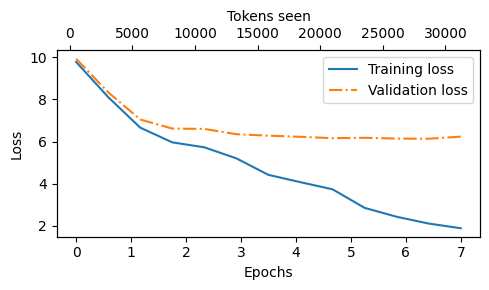

In [36]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()


epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [37]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_tokens(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded, max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))

In [38]:
generate_and_print_sample(model, tokenizer, device, start_context="Man plays")

Man plays the sunlit terrace.  I glanced after him, and uncertain.  "I was no--as! The women had been, in the moment--as Jack himself, one might put it, the donkey, and were, and


### 5.2.1. Adding Tensorboard for Monitoring

In [41]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter("../../runs/GPT2_TinyData")

In [42]:
def train_model_simple_tb(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs,
    eval_freq,
    eval_iter,
    start_context,
    tokenizer,
):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(
                    f"Ep {epoch+1} (Step {global_step:06d}): "
                    f"Train loss {train_loss:.3f}, "
                    f"Val loss {val_loss:.3f}"
                )
                writer.add_scalar("Loss/Train", train_loss, epoch)
                writer.add_scalar("Loss/Test", val_loss, epoch)

        generate_and_print_sample(model, tokenizer, device, start_context)
    writer.add_graph(model, input_batch)
    return train_losses, val_losses, track_tokens_seen

In [ ]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to("cpu")
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)
num_epochs = 7
train_losses, val_losses, tokens_seen = train_model_simple_tb(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5,
    start_context="Cat is sleeping",
    tokenizer=tokenizer,
)

## 5.3. Decoding Strategies to Control Randomness

In [39]:
model.to("cpu")
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attn_block): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feedforward_block): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (layer_norm_1): LayerNorm()
      (layer_norm_2): LayerNorm()
      (droput): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attn_block): MultiHeadAttention(
     

In [40]:
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model=model,
    idx=text_to_tokens("Every effort moves you", tokenizer=tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"],
)

In [41]:
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know," was one of the picture for nothing--I told Mrs.

"I was no--as! The women


### 5.3.1. Temperature Scaling

#### 5.3.1.1. Toy Example

In [ ]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}
inverse_vocab = {v: k for k, v in vocab.items()}

## suppose context is, "Every step moves you"

In [43]:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id])

forward


In [ ]:
## Adding Probabilistic Sampling using multinomial distribution
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

forward


In [46]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")


print_sampled_tokens(probas)

73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward


#### 5.3.1.2. Softmax with Temperature

Distribution and Selection Process is controlled via concept called `Temperature Scaling`. Final Logits is divided by number greater than 0

* Temperature greater than 1 result in uniformly distributed token probabilities
* Temperatures smaller than 1 will lead to sharper / Peaky Distributions

In [47]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

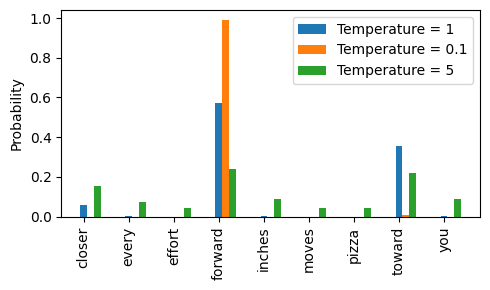

In [52]:
temperatures = [1, 0.1, 5]
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]
x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(
        x + i * bar_width, scaled_probas[i], bar_width, label=f"Temperature = {T}"
    )
ax.set_ylabel("Probability")
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

### 5.3.2. Top-K Sampling

Temperature alloaws to control how peaky we want the token probablities to be peaky, but downside is that it could sometimes leads to grammatically incorrect or completly nonsensical outputs such as

`every effort moves you pizza`

**Top-K Sampling**

- Number of tokens to sample is limiyed to Top-K most likely token and exclude all other tokens from selection from process before applying softmax or temperature scaling

Logits --> Top-k --> -inf mask --> Softmax

By assigning zero probabilities to the non-top-k positions, we ensure that the next token is always from sampled from a top-k position

In [53]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [54]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float("-inf")),
    other=next_token_logits,
)

print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [55]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


### 5.3.3. Modification of Text Generation Function